In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [5]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [7]:
user_length.min(), user_length.max()

(20, 2314)

In [8]:
user_length.quantile(0.9)

400.0

In [9]:
user_length.quantile(0.95)

556.0

In [10]:
long_user = user_length[user_length == 556].index[0]
data[data['UserId']==long_user]


,UserId,ItemId,Rating,Time
265026,1611,1100,3,974729734
265119,1611,3102,4,974729751
265359,1611,1221,5,974729751
264895,1611,902,4,974729793
265093,1611,805,4,974729845
...,...,...,...,...
264847,1611,3799,1,1004882525
265047,1611,3671,4,1006222187
265213,1611,2706,4,1013346583
264963,1611,1655,3,1015766322


In [11]:
length_count = user_length.groupby(user_length).size()
length_count

20      86
21      91
22      77
23      81
24      81
        ..
1521     1
1595     1
1743     1
1850     1
2314     1
Length: 743, dtype: int64

In [12]:
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_95 = length_percent_cumsum[length_percent_cumsum < 0.95]
length_percent_cumsum_95

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
549    0.948344
550    0.948675
551    0.949007
552    0.949338
554    0.949834
Length: 507, dtype: float64

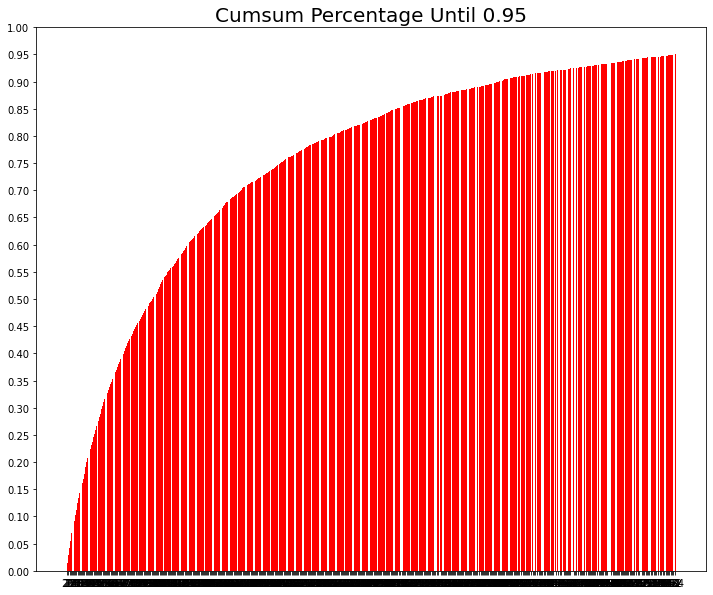

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_95.index,
       height = length_percent_cumsum_95, color='red')
plt.xticks(length_percent_cumsum_95.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.95', size=20)
plt.show()

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [15]:
#타임스탬프 정보로 시간을 알기 어려워 gmtime 사용하여 UTC 시간포맷으로 변경
import time

time_old = time.gmtime(oldest)
print(time_old)

time_latest = time.gmtime(latest)

time_latest

time.struct_time(tm_year=2000, tm_mon=4, tm_mday=25, tm_hour=23, tm_min=5, tm_sec=32, tm_wday=1, tm_yday=116, tm_isdst=0)


time.struct_time(tm_year=2003, tm_mon=2, tm_mday=28, tm_hour=17, tm_min=49, tm_sec=50, tm_wday=4, tm_yday=59, tm_isdst=0)

<AxesSubplot:xlabel='Rating'>

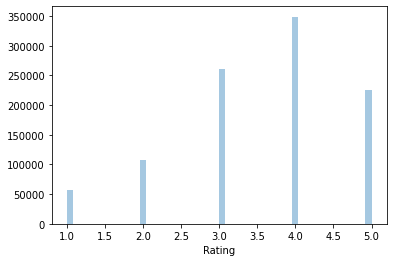

In [16]:
#Rating 분포 확인.  
import seaborn as sns
sns.distplot(data['Rating'], kde=False)


In [17]:
#1점과 2점 평점은 소수이므로 제외를 해주겠다.
data = data[data['Rating']>=3]

In [18]:
#평점을 사용하여 추천 모델을 돌릴 때 평점 정보가 시게열에 영향을 받지 않는다고 생각해서 시간 컬럼을 삭제하기로 했다. (초기 평점은 낮고 최신 평점은 높다고 해서 다음 평점이 높을 가능성이 있다고 말할 수 없으므로)
data = data.drop(['Time'], axis=1)
data

,UserId,ItemId,Rating
31,1,3186,4
22,1,1270,5
27,1,1721,4
37,1,1022,5
24,1,2340,3
...,...,...,...
1000019,6040,2917,4
999988,6040,1921,4
1000172,6040,1784,3
1000167,6040,161,3


In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=1000)
train, valid = train_test_split(train, test_size=0.2, random_state=1000)
print(len(train), len(valid), len(test))

535345 133837 167296


In [20]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t User: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n')


In [21]:
stats_info(train, 'train')
stats_info(valid, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 535345
	 User: 6039
	 Items: 3570

* valid Set Stats Info
	 Events: 133837
	 User: 6007
	 Items: 3321

* test Set Stats Info
	 Events: 167296
	 User: 6026
	 Items: 3377



In [22]:
# train set에 6039명의 유저가 있어 전체 6040명 중 1명이 빠져 있다. 그 한명이 test 유저에 있을 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {User_id : index for index, User_id in enumerate(train['ItemId'].unique())}


def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train = indexing(train, id2idx)
valid = indexing(valid, id2idx)
test = indexing(test, id2idx)

In [23]:
# data pipeline을 구축
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
valid.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [24]:
#  User-Parallel Mini-Batch 를 구현
class UserDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each user IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [25]:
train_dataset = UserDataset(train)
train_dataset.df.head(10)

,UserId,ItemId,Rating,item_idx
97937,655,1777,3,0
251635,1522,3701,4,1
971763,5854,839,3,2
197916,1216,1374,3,3
224683,1358,1301,5,4
952847,5755,260,4,5
45093,303,3783,3,6
685744,4099,1078,4,7
302047,1794,208,3,8
468239,2887,1605,3,9


In [26]:
train_dataset.click_offsets

array([     0,     31,    111, ..., 535099, 535169, 535345], dtype=int32)

In [27]:
train_dataset.user_idx

array([   0,    1,    2, ..., 6036, 6037, 6038])

In [28]:
class UserDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: UserDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_user, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_user, finished = self.update_status(start, end, min_len, last_user, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_user = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.user_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.user_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_user, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_user: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_user = last_user + i  
            if new_user > self.dataset.user_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user] + 1]

        last_user += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_user, finished

In [30]:
train_data_loader = UserDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,item_idx
97937,655,1777,3,0
251635,1522,3701,4,1
971763,5854,839,3,2
197916,1216,1374,3,3
224683,1358,1301,5,4
952847,5755,260,4,5
45093,303,3783,3,6
685744,4099,1078,4,7
302047,1794,208,3,8
468239,2887,1605,3,9


In [31]:
iter_ex = iter(train_data_loader)

In [32]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  31 107 136]
Label Item Idx are :       [  1  32 108 123]
Previous Masked Input Idx are []


In [33]:
# MRR과 Recall@k
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [35]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [37]:
class Args:
    def __init__(self, train, valid, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.train = train
        self.valid = valid
        self.test = test
        self.num_items = train['ItemId'].nunique()
        self.num_user = train['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, valid, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [38]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 3570)]         0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  543300    
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 3570)              182070    
Total params: 725,370
Trainable params: 725,370
Non-trainable params: 0
_________________________________________________________________


In [39]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = UserDataset(args.train)
    train_loader = UserDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.train) - args.train['UserId'].nunique()
        train_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in train_loader:
            reset_hidden_states(model, mask)  # 종료된 User는 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            train_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        valid_recall, valid_mrr = get_metrics(args.valid, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {valid_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {valid_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserDataset(data)
    loader = UserDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [40]:
train_model(model, args)

# 학습된 모델을 불러옵니다.
model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  60%|█████▉    | 37/62 [05:20<03:36,  8.66s/it]


	 - Recall@20 epoch 1: 0.059584
	 - MRR@20    epoch 1: 0.011911



Evaluation:  60%|█████▉    | 37/62 [05:19<03:35,  8.63s/it]


	 - Recall@20 epoch 2: 0.059702
	 - MRR@20    epoch 2: 0.011942



Evaluation:  60%|█████▉    | 37/62 [05:16<03:34,  8.56s/it]


	 - Recall@20 epoch 3: 0.059715
	 - MRR@20    epoch 3: 0.011947



# 회고:
    
실습데이터 movielens 데이터에 시간 정보가 있어 사용하고 싶었으나 적용하기 위해서는 GRU4REC 논문 이후에 나온 최신 논문을 적용해야 할 것 같았다. 
찾아보니 최근에는 어텐션과 트랜스포머 개념이 적용된 논문이 많이 나오고 있다고 한다. 그런데 시간 정보를 사용했다고 해도 이 데이터는 성능이 그렇게 좋지는 않았을 것 같다. 
추천 시스템에는 유저의 다양한 정보가 활용되어야 정확도가 높다고 하는데 실습 데이터에는 userID 밖에 없어서 추천시스템에 맞는 데이터가 아닌 것 같았다. 
함수와 클래스 선언하는 기나긴 코드가 너무 부담스러운 노드였다. 
항상 시간에 쫒기며 하느라 제대로 이해를 못한 부분이 많아 아쉬웠다.     